In [ ]:
import os
exists = os.path.isfile('readtria.py')
if not(exists):
    print("Downloading meshes ...")
    !git clone https://github.com/dpeschka/NumFluids.git
    !cp -r NumFluids/notebook/meshes .
    !cp NumFluids/notebook/readtria.py .
else:
    print("All is set.")

# Lecture 05: Advanced Finite Element Method 2D

In the attached lecture you see some extensions of the finite element code that we discussed the last time.

read mesh file: ./meshes/disc3


(-1.09996325, 1.09999825, -1.0999900999999999, 1.0999900999999999)

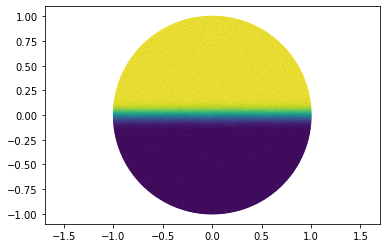

In [20]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve,splu
from scipy.spatial import Delaunay

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from readtria import readtria, writevtk

def square_mesh(L=1.0,k=16):
    h = L/k
    xh, yh = np.meshgrid(np.linspace(0,L,k), np.linspace(0,L,k)) 
    xh     = xh.flatten()
    yh     = yh.flatten()
    points = np.array([xh,yh]).T
    tri    = Delaunay(points)
    e2     = tri.simplices
    
    nelement = np.size(e2,0)
    npoint   = np.size(xh,0)
    
    idp      = np.zeros(npoint)
    idp[(xh<h/2)|(yh<h/2)|(xh>(L-h/2))|(yh>(L-h/2))] = 1
    ide      = []
    return xh,yh,npoint,nelement,e2,idp,ide

def generate_transformation2D(k, e2, x, y):
    dx1 = x[e2[k, 1]]-x[e2[k, 0]]
    dy1 = y[e2[k, 1]]-y[e2[k, 0]]

    dx2 = x[e2[k, 2]]-x[e2[k, 0]]
    dy2 = y[e2[k, 2]]-y[e2[k, 0]]

    # determinant on each triangle
    Fdet = dx1*dy2 - dx2*dy1

    # transformation Jacobian on each triangle
    Finv = np.zeros((2, 2))
    Finv[0, 0] =  dy2 / Fdet
    Finv[0, 1] = -dx2 / Fdet
    Finv[1, 0] = -dy1 / Fdet
    Finv[1, 1] =  dx1 / Fdet

    return Fdet, Finv

# computes the local stiffness matrix in 2D, i.e. int grad(w_i)*grad(w_j) dx
# by transformation to reference, where the shape functions phi are used
def local_stiff2D(a,Fdet, Finv):
    gradphi = np.array([[-1, -1], [1, 0], [0, 1]]).T
    dphi    = np.matmul(Finv.T,gradphi)
    S = a/2*np.matmul(dphi.T,dphi)*Fdet
    return S

# computes the local convection matrix in 2D, i.e. int w_i u*grad(w_j) dx
def local_conv2D(uvec,Fdet, Finv):
    locmass = np.array([[1, 1/2, 1/2], [1/2, 1, 1/2], [1/2, 1/2, 1]])/12.0
    gradphi = np.array([[-1, -1], [1, 0], [0, 1]]).T
    dphi    = np.matmul(Finv.T,gradphi)
    C = np.matmul(np.matmul(locmass,uvec),dphi)*Fdet
    return C

# computes the local mass matrix in 2D, i.e. int w_i w_j dx
def local_mass2D(c,Fdet):
    return c*Fdet*np.array([[1, 1/2, 1/2], [1/2, 1, 1/2], [1/2, 1/2, 1]])/12

# FEM Python sample code
# x, y, npoint, nelement, e2, idp, ide = readtria('./meshes/house.1')  # read mesh from file
#x, y, npoint, nelement, e2, idp, ide = readtria('./meshes/cheese')  # read mesh from file
#x,y,npoint,nelement,e2,idp,ide = square_mesh(1.0,64)  # read mesh from file
x, y, npoint, nelement, e2, idp, ide = readtria('./meshes/disc3')  # read mesh from file

localtoglobal2DP1           = e2                  # could it be this simple? why?

# select points without Dirichlet bc
it = np.logical_not(idp == 1)
nphi = 3

# build matrices
ii = np.zeros((nelement, nphi**2))  # sparse i-index
jj = np.zeros((nelement, nphi**2))  # sparse j-index
aa = np.zeros((nelement, nphi**2))  # entry of Galerkin matrix
bb = np.zeros((nelement, nphi**2))  # entry in mass-matrix (to build rhs)

for k in np.arange(0, nelement):
    Fdet, Finv = generate_transformation2D(k, e2, x, y)  # compute trafo
    
    # build local matrices (mass, stiffness, ...)
    a = lambda x,y: 1e-3 + 0*x.T
    c = lambda x,y:  1.0 + 0*x.T
    u = lambda x,y: np.array((-y,x)).T
    
    # center points (xm,ym) and nodal points (xe,ye) of element
    xe   = x[e2[k,:]]
    ye   = y[e2[k,:]]
    xm   = np.mean(xe)
    ym   = np.mean(ye)
    
    sloc = local_stiff2D(a(xm,ym),Fdet,Finv) # element stiffness matrix
    mloc = local_mass2D (c(xm,ym),Fdet     ) # element mass matrix
    cloc = local_conv2D (u(xe,ye),Fdet,Finv) # element convection matrix
    
    # compute i,j indices of the global matrix
    dofs = localtoglobal2DP1[k,:]
    ii[k, :] = dofs[[0,0,0,1,1,1,2,2,2]]  # local-to-global
    jj[k, :] = dofs[[0,1,2,0,1,2,0,1,2]]  # local-to-global
    
    # compute a(i,j) values of the global matrix
    aloc = sloc + cloc
    aa[k, :] = aloc.flatten()
    bb[k, :] = mloc.flatten()

# create sparse matrices
L = sparse.csc_matrix((aa.flatten(),(ii.flatten(),jj.flatten())),shape=(npoint,npoint))
M = sparse.csc_matrix((bb.flatten(),(ii.flatten(),jj.flatten())),shape=(npoint,npoint))

# build rhs and take into account Dirichlet bcs, solve, plot
w = np.tanh(50*x)

Nt = 250
tau = np.pi/(2*Nt)

A = M + tau*L/2
B = M - tau*L/2

ALU = splu(A)

fnum = 0
for k in range(Nt):
    rhs = B*w
    w   = ALU.solve(rhs)
    if (k % 10 == 0):
        writevtk(f'simu_lect06_{fnum:05d}.vtk',x,y,e2,w,'test')
        fnum = fnum + 1

plt.figure()
plt.tripcolor(x,y,w,triangles=e2,shading='gouraud')
plt.triplot(x,y,triangles=e2,linewidth=0.05)
plt.axis('equal')